In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
from FSC_DoubleGrad import InferenceDiscreteObs as FSC_DoubleGrad_InferenceDiscreteObs
import ObsModels 

In [3]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations, one step

In [33]:
NStepsObs = 1
NTraj = 500
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [34]:
M = 2
A = 2

np.random.seed(0)
Theta = np.random.randn(Y, M, M, A)

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [35]:
FSC.load_observations(observations)

In [36]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

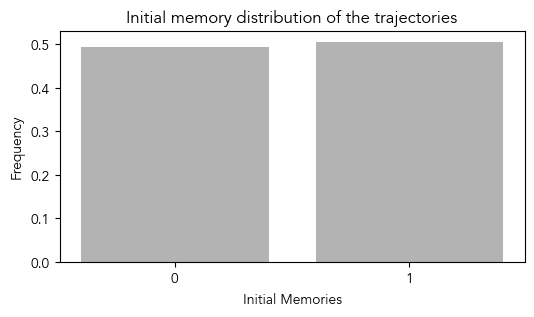

In [37]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [38]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.4169199915511197

### Inference (gradient-based)

In [39]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.6199, device='mps:0', grad_fn=<SubBackward0>)

In [40]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [41]:
MSE = FSC_tofit.optimize_psionly(method = 'L-BFGS-B')

### Inference (SGD)

In [42]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.1349, device='mps:0', grad_fn=<SubBackward0>)

In [43]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [44]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 40, NBatch = 100, lr = 0.1, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.7374905967712402, Validation loss: 0.7035907366871834 - Learning rate: 0.1
Epoch 2 - Training loss: 0.7280765342712403, Validation loss: 0.6937593612074852 - Learning rate: 0.09000000000000001
Epoch 3 - Training loss: 0.7144135093688965, Validation loss: 0.6795176857709885 - Learning rate: 0.08100000000000002
Epoch 4 - Training loss: 0.6937646293640137, Validation loss: 0.6632929672300816 - Learning rate: 0.07290000000000002
Epoch 5 - Training loss: 0.6761819648742675, Validation loss: 0.6496004423499108 - Learning rate: 0.06561000000000002
Epoch 6 - Training loss: 0.6611312198638917, Validation loss: 0.6437498855590821 - Learning rate: 0.05904900000000002
Epoch 7 - Training loss: 0.6579535675048828, Validation loss: 0.6446726846694947 - Learning rate: 0.05314410000000002
Epoch 8 - Training loss: 0.6583479881286621, Validation loss: 0.6473491996526718 - Learning rate: 0.04782969000000002
Epo

### Comparison

In [45]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

FSC_inferred_SDG = FSC_DiscreteObs(FSC_SDG.theta.detach().cpu().double().numpy(),
                                 FSC_SDG.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.
Initializing FSC with 2 memory states, 2 actions, and 2 observations.


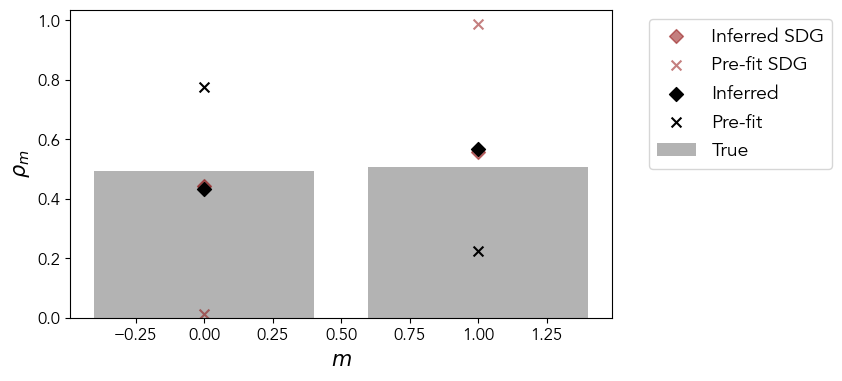

In [46]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_SDG.rho, color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations, one step

In [47]:
NStepsObs = 1
NTraj = 500
Y = 5
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [48]:
M = 2
A = 2

np.random.seed(9)
Theta = np.random.randn(Y, M, M, A)

Psi = np.array([1.25, 1])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 5 observations.


In [49]:
FSC.load_observations(observations)

In [50]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

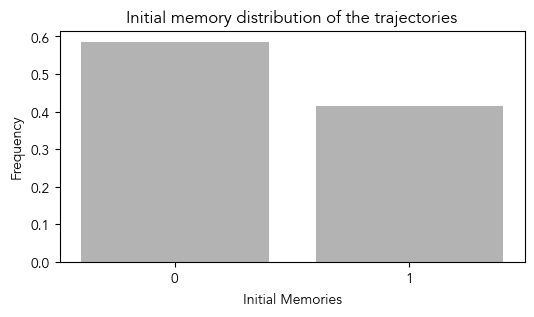

In [51]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [52]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.5221538198822843

### Inference (gradient-based)

In [53]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.4661, device='mps:0', grad_fn=<SubBackward0>)

In [54]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [55]:
MSE = FSC_tofit.optimize_psionly(method = 'L-BFGS-B')

### Inference (SGD)

In [56]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.6837, device='mps:0', grad_fn=<SubBackward0>)

In [57]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [58]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 40, NBatch = 100, lr = 0.1, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 0.728818702697754, Validation loss: 0.6865628986060619 - Learning rate: 0.1
Epoch 2 - Training loss: 0.7235995483398437, Validation loss: 0.6826292832195758 - Learning rate: 0.09000000000000001
Epoch 3 - Training loss: 0.715342674255371, Validation loss: 0.6767974725365639 - Learning rate: 0.08100000000000002
Epoch 4 - Training loss: 0.7034136581420898, Validation loss: 0.6698718407750129 - Learning rate: 0.07290000000000002
Epoch 5 - Training loss: 0.6905438423156738, Validation loss: 0.6632894855737687 - Learning rate: 0.06561000000000002
Epoch 6 - Training loss: 0.6800711250305175, Validation loss: 0.6590393370389939 - Learning rate: 0.05904900000000002
Epoch 7 - Training loss: 0.6749823379516601, Validation loss: 0.658060359954834 - Learning rate: 0.05314410000000002
Epoch 8 - Training loss: 0.6727805709838868, Validation loss: 0.6592281693220139 - Learning rate: 0.04782969000000002
Epoch 

### Comparison

In [59]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

FSC_inferred_SDG = FSC_DiscreteObs(FSC_SDG.theta.detach().cpu().double().numpy(),
                                 FSC_SDG.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 5 observations.
Initializing FSC with 2 memory states, 2 actions, and 5 observations.


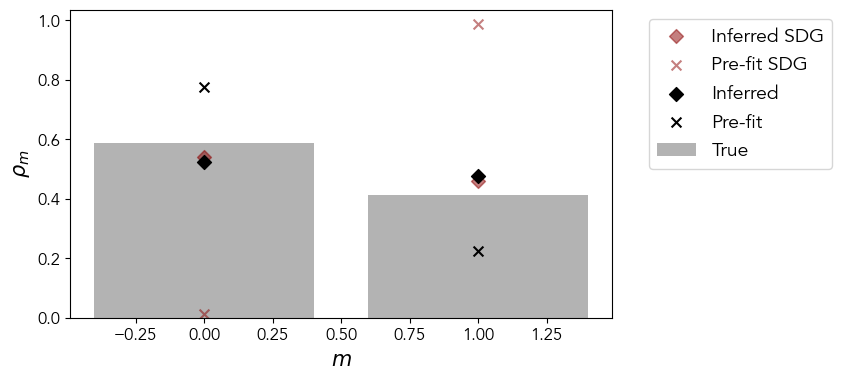

In [60]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_SDG.rho, color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finite State Controller with $M = 6$, $A = 3$, $Y = 4$

# Observations, one step

In [80]:
NStepsObs = 1
NTraj = 500
Y = 4
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [81]:
M = 6
A = 3

np.random.seed(6)
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 6 memory states, 3 actions, and 4 observations.


In [82]:
FSC.load_observations(observations)

In [83]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

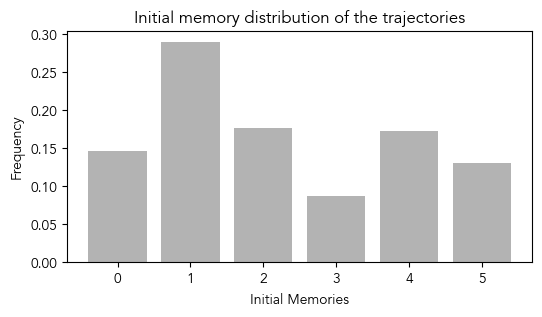

In [84]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [85]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.1630620803781582

### Inference (gradient-based)

In [94]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.3860, device='mps:0', grad_fn=<SubBackward0>)

In [95]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [96]:
MSE = FSC_tofit.optimize_psionly(method = 'trust-ncg')

### Inference (SGD)

In [97]:
FSC_SDG = FSC_DoubleGrad_InferenceDiscreteObs(M, A, Y, seed = 1234)
FSC_SDG.load_theta(Theta.astype(np.float32))
FSC_SDG.load_trajectories(trajectories)
FSC_SDG.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.0145, device='mps:0', grad_fn=<SubBackward0>)

In [98]:
psi_pre_fit_SDG = FSC_SDG.psi.detach().cpu().numpy()
rho_pre_fit_SDG = FSC_SDG.rho.detach().cpu().numpy()

In [99]:
tloss, vloss = FSC_SDG.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 1.0948882293701172, Validation loss: 1.0697682344913482 - Learning rate: 0.01
Epoch 2 - Training loss: 1.0947322845458984, Validation loss: 1.0698372679948807 - Learning rate: 0.0099
Epoch 3 - Training loss: 1.094768943786621, Validation loss: 1.0697418653964996 - Learning rate: 0.009801
Epoch 4 - Training loss: 1.0946267318725584, Validation loss: 1.0697915548086165 - Learning rate: 0.00970299
Epoch 5 - Training loss: 1.0946072387695314, Validation loss: 1.0699140602350234 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 1.0945544052124023, Validation loss: 1.0700003999471663 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 1.0945418930053712, Validation loss: 1.0700963485240935 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 1.094478645324707, Validation loss: 1.0700959366559983 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 1.0944446563720702, Validati

### Comparison

In [100]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

FSC_inferred_SDG = FSC_DiscreteObs(FSC_SDG.theta.detach().cpu().double().numpy(),
                                 FSC_SDG.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 6 memory states, 3 actions, and 4 observations.
Initializing FSC with 6 memory states, 3 actions, and 4 observations.


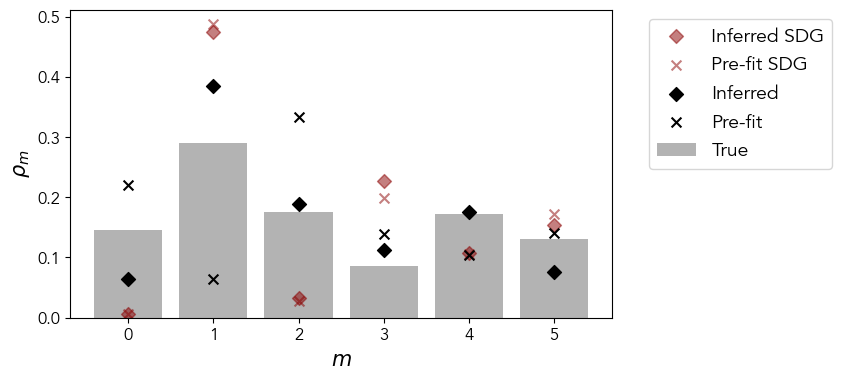

In [101]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_SDG.rho, color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)
ax.scatter(np.arange(M), rho_pre_fit_SDG, color = "darkred", marker = "x", s = 50, label = "Pre-fit SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Analytic tests

In [102]:
NTraj = int(1e5)
observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [103]:
FSC.load_observations(observations)

In [104]:
NSteps = NStepsObs
trajectories_all = FSC.generate_trajectories(NSteps)

In [105]:
ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories_all])

# this is the conditional probability of the action given the observation
pAgY = np.zeros((Y, A))

for y in range(Y):
    pAgY[y] = np.histogram(ya_array[ya_array[:,0] == y, 1], bins = np.arange(-0.5, A+0.5, 1))[0]

    # normalize

    pAgY[y] = pAgY[y]/np.sum(pAgY[y])

pya = pAgY/Y

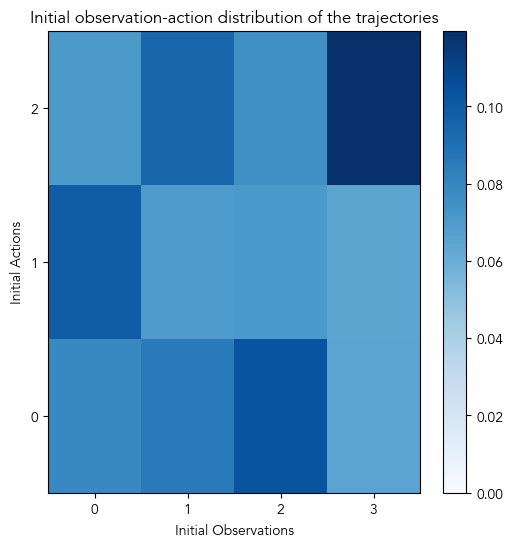

In [106]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ObsGrid, ActGrid = np.meshgrid(np.arange(Y), np.arange(A))

im = ax.pcolormesh(ObsGrid, ActGrid, pya.T, cmap = 'Blues', vmin = 0)

ax.set_xlabel('Initial Observations')
ax.set_ylabel('Initial Actions')

ax.set_xticks(np.arange(0, Y, 1))
ax.set_yticks(np.arange(0, A, 1))

ax.set_title('Initial observation-action distribution of the trajectories')

plt.colorbar(im, ax = ax)

plt.show()

In [107]:
wVec = FSC.TMat.sum(axis = 2)
qVec = np.exp(FSC.psi)
tempVec = np.zeros((Y, A, M))

for y in range(Y):
    for a in range(A):
        tempVec[y,a,:] = wVec[y, :, a]*qVec
        tempVec[y,a,:] = tempVec[y,a,:]/np.sum(tempVec[y,a,:])

rhoTilde = np.sum(pya[..., None]*tempVec, axis = (0,1))

print("True rho: ", FSC.rho)
print("Rho tilde: ", rhoTilde)

True rho:  [0.15339996 0.28168368 0.183567   0.0729916  0.16127062 0.14708714]
Rho tilde:  [0.15322372 0.28203138 0.18343433 0.07297701 0.16133908 0.14699449]


In [112]:
FSC_tofit_large = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit_large.load_theta(Theta.astype(np.float32))
FSC_tofit_large.load_trajectories(trajectories_all)

MSE = FSC_tofit_large.optimize_psionly(method = "trust-ncg")

In [113]:
FSC_tofit_large.pStart_ya_emp, pya

(array([[0.0794 , 0.10036, 0.07121],
        [0.08497, 0.07009, 0.09469],
        [0.10275, 0.07053, 0.07478],
        [0.06598, 0.06504, 0.1202 ]]),
 array([[0.07909312, 0.09997211, 0.07093477],
        [0.08505506, 0.07016016, 0.09478478],
        [0.10355358, 0.07108159, 0.07536483],
        [0.06565958, 0.06472415, 0.11961627]]))

In [114]:
FSC_inferred_large = FSC_DiscreteObs(FSC_tofit_large.theta.detach().cpu().double().numpy(),
                                     FSC_tofit_large.psi.detach().cpu().double().numpy(), verbose = True)


Initializing FSC with 6 memory states, 3 actions, and 4 observations.


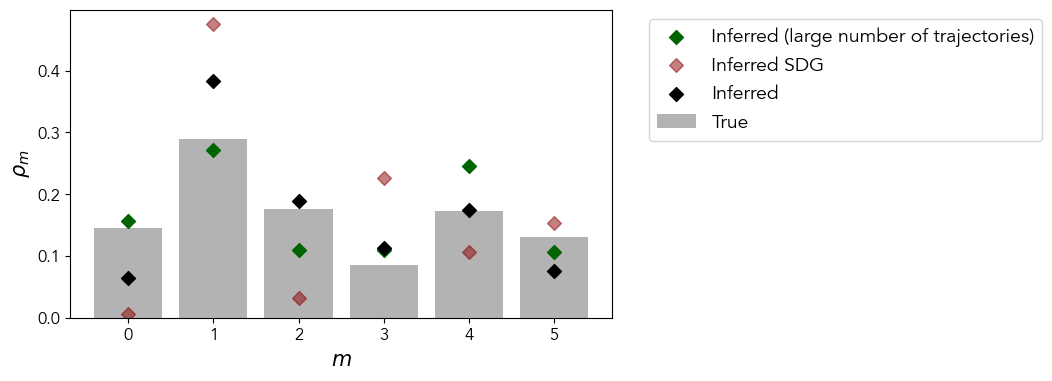

In [115]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")

ax.scatter(np.arange(M), FSC_inferred_large.rho, color = "darkgreen", marker = "D", s = 50, label = "Inferred (large number of trajectories)")

ax.scatter(np.arange(M), FSC_inferred_SDG.rho, color = "darkred", marker = "D", s = 50, label = "Inferred SDG", alpha = 0.5)

ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")


ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()